# FGD1
[Aarskog-Scott syndrome (AAS)](https://www.omim.org/entry/305400) can be caused by mutation in the FGD1 gene.


In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### FGD1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FGD1.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'FGD1'
mane_tx_id = 'NM_004463.3'
mane_protein_id = 'NP_004454.2' # FYVE, RhoGEF and PH domain-containing protein 1
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 48 phenopackets
Individuals Processed: 100%|██████████| 48/48 [00:00<00:00, 60.64 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
46,Short stature
45,Hypertelorism
38,Anteverted nares
36,Shawl scrotum
34,Long philtrum
32,Short nose
31,Ptosis
28,Cryptorchidism
25,Brachydactyly
23,Clinodactyly of the 5th finger


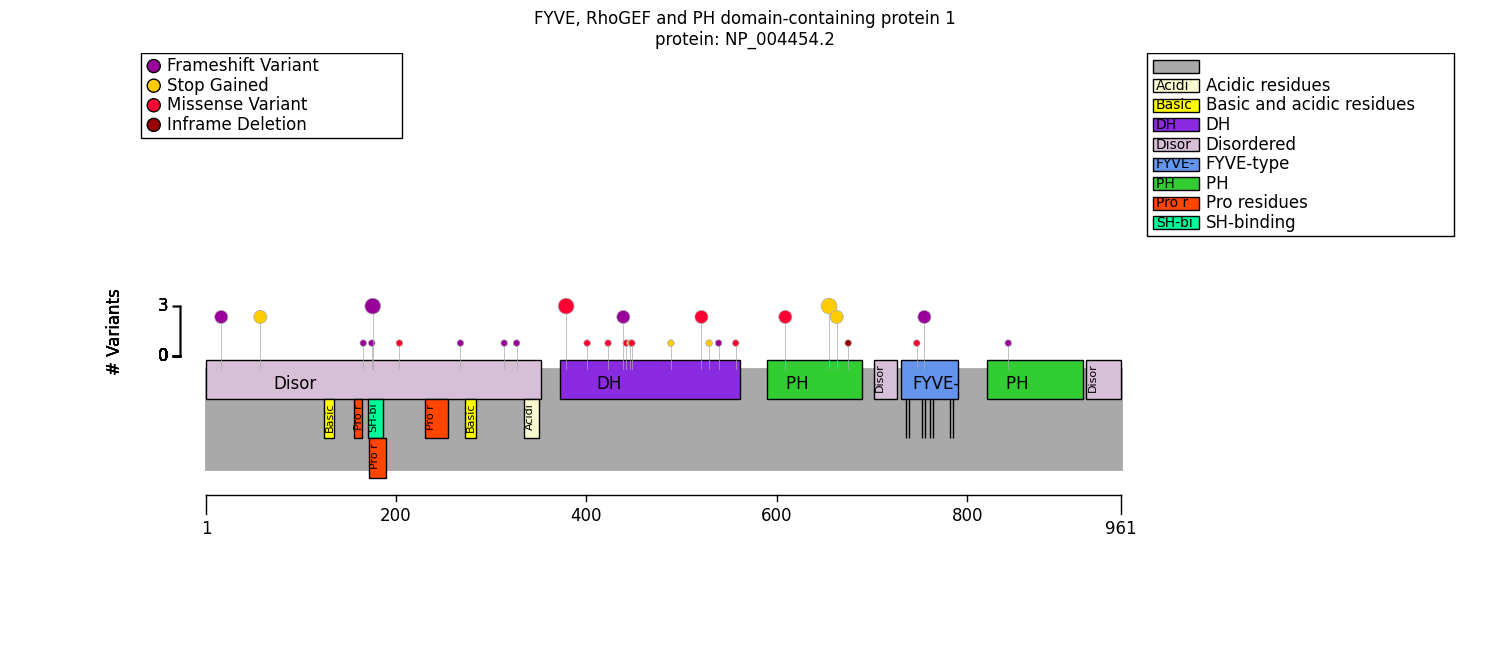

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

fgd1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
fgd1_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
13,Disordered,Region,2 - 353,p.Pro18ArgfsTer106; p.Gln59Ter; p.Leu177ThrfsTer40; p.Leu177ProfsTer40; p.Pro315ArgfsTer11; p.Ala269ValfsTer91; p.Tyr167SerfsTer48; p.His328ThrfsTer32; p.Ser205Ile
0,Basic and acidic residues,Compositional bias,126 - 135,
0,Pro residues,Compositional bias,157 - 165,
4,SH3-binding,Motif,172 - 187,p.Leu177ThrfsTer40; p.Leu177ProfsTer40
4,Pro residues,Compositional bias,173 - 190,p.Leu177ThrfsTer40; p.Leu177ProfsTer40
0,Pro residues,Compositional bias,232 - 255,
0,Basic and acidic residues,Compositional bias,274 - 284,
0,Acidic residues,Compositional bias,336 - 351,
16,DH,Domain,374 - 561,p.Leu440ArgfsTer31; p.Trp447Ter; p.Gln490Ter; p.Arg449Cys; p.Arg402Gln; p.Glu380Ter; p.Ser558Trp; p.Glu380Ala; p.Tyr530Ter; p.Asp540GlufsTer11; p.Arg443His; p.Asn424Asp; p.Arg522His
8,PH 1,Domain,591 - 689,p.Arg656Ter; p.Gln664Ter; p.Glu676del; p.Arg610Leu


# Genotype Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,22
"Skipping ""general"" level terms",61
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),134


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Other,Corrected p values,p values
Broad foot [HP:0001769],1/7 (14%),14/15 (93%),0.032320,0.000622
Cryptorchidism [HP:0000028],4/11 (36%),24/31 (77%),0.621776,0.023914
Umbilical hernia [HP:0001537],4/10 (40%),2/20 (10%),1.000000,0.141316
Ptosis [HP:0000508],7/13 (54%),24/31 (77%),1.000000,0.155235
Short nose [HP:0003196],10/13 (77%),22/24 (92%),1.000000,0.320918
Shawl scrotum [HP:0000049],10/13 (77%),26/29 (90%),1.000000,0.352548
Downslanted palpebral fissures [HP:0000494],5/10 (50%),15/22 (68%),1.000000,0.438237
Short stature [HP:0004322],12/13 (92%),34/35 (97%),1.000000,0.472518
Broad philtrum [HP:0000289],2/6 (33%),3/19 (16%),1.000000,0.562281
Anteverted nares [HP:0000463],10/12 (83%),28/31 (90%),1.000000,0.607749


In [10]:
from gpsea.analysis.predicate import protein_feature

# DH Domain
dh = protein_feature(
    feature_id="DH", protein_metadata=protein_meta
)
dh_clf = monoallelic_classifier(
    a_predicate=dh,
    b_predicate=~dh,
    a_label="DH domain",
    b_label="Other"
)
dh_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=dh_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=dh_result)

Allele group,DH domain,Other,Corrected p values,p values
Cryptorchidism [HP:0000028],5/13 (38%),23/29 (79%),0.664696,0.014773
Umbilical hernia [HP:0001537],5/12 (42%),1/18 (6%),0.664696,0.025565
Single transverse palmar crease [HP:0000954],7/8 (88%),8/15 (53%),1.000000,0.176328
Hypospadias [HP:0000047],2/11 (18%),1/22 (5%),1.000000,0.252016
Clinodactyly of the 5th finger [HP:0004209],5/7 (71%),18/20 (90%),1.000000,0.269231
Short nose [HP:0003196],11/14 (79%),21/23 (91%),1.000000,0.345875
Dental malocclusion [HP:0000689],1/6 (17%),6/14 (43%),1.000000,0.354360
Long philtrum [HP:0000343],12/13 (92%),22/29 (76%),1.000000,0.398328
Short philtrum [HP:0000322],0/8 (0%),3/16 (19%),1.000000,0.525692
Broad foot [HP:0001769],4/7 (57%),11/15 (73%),1.000000,0.630224


# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=dh_result,
    ),
)

caption = """Li et al (2024) identified a number of correlations including a lower frequency of Deformity of foot	
(8/20) with missense than with "drastic" variants (29/41); p=0.03. Multiple testing correction was not performed \\cite{PMID_38411716,PMID_33762894}. """
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [13]:
summarizer.process_latex(report=report, protein_fig=fgd1_fig)

Figure saved to ../../supplement/img/FGD1_protein_diagram-draft.pdf
Output to ../../supplement/tex/FGD1_summary_draft.tex
